In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import numpy.linalg as LA

In [2]:
from algorithms.meshforrectangle import MeshForRectangle

In [3]:
w = 1
h = 2
rectangle = [[0,0],[0,h],[w,h],[w,0]]
rectangle_area = h*w

u = lambda x, y: (x - 1)**2 * (y - 2)**2 *x*y
a11 = 1
a22 = 1
#a12 = 0
#a21 = 0

d = 0
#f = lambda x, y: 2

# f = lambda x, y: 2 * x * (x - 1)**2 * (3*y - 4) + 2*(3*x - 2)*(y - 2)**2 * y
f = lambda x, y: 2*(-2+3*x)*(-2+y)**2*y+2*(-1+x)**2*x*(-4+3*y)
# f = lambda x, y: x**3+y**3

beta = 1e-10
sigma = 1e+10
psi = 0

In [4]:
nx = 32
ny = 64
mesher = MeshForRectangle(nx, ny)
triangulation = list(map(lambda t: t.get_points(), mesher.triangulate(rectangle)))

In [5]:
points = np.unique(np.concatenate(triangulation), axis=0).tolist()
triangles = list(map(lambda tri: [points.index(tri[0]),
                                  points.index(tri[1]),
                                  points.index(tri[2]),], triangulation))

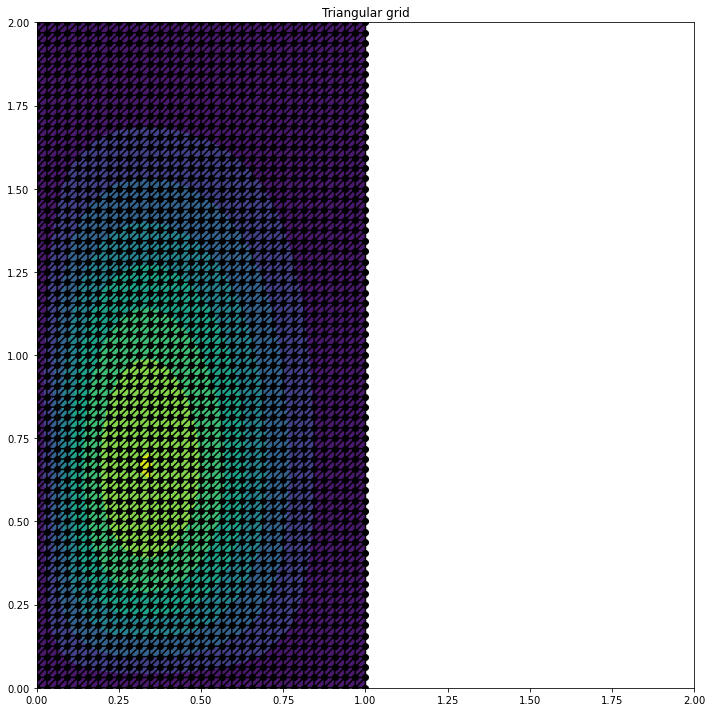

In [6]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
ax.tricontourf(triang, z)
ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')

fig.tight_layout()
plt.savefig('s.pdf')
plt.show()

In [7]:
n =  len(triangles)
triangle_area = rectangle_area / n
s = triangle_area

def K_i(b, c, s, a11, a22):
    K = np.zeros([3, 3])
    for i in range(3):
        for j in range(3):
            K[i][j] = (a11 * (b[i] * b[j]) + a22 * (c[i] * c[j]))

    K = K / (2 * 2 * s)
    return K


def fill_A_with_K_i(A, K, tri):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += K[i][j]  
    
def fill_A_with_M_i(A, M, tri, d):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += d * M[i][j]   
            
def fill_F_with_phi_i(F, tri, points, M):
#     Me = np.array(M)
    Qe = np.zeros(3);
    Me = np.sum(M,axis=1)
    for i in range(3):
        Qe[i] = -Me[i] * f(*points[tri[i]])
#     Qe = -Me.dot(
#         np.array([ [ f(*points[tri[0]]) ], [ f(*points[tri[1]]) ], [ f(*points[tri[2]]) ]])
#     )
#     print(Qe)
#     Qe = np.array([ [ f(*points[tri[0]]) ], [ f(*points[tri[1]]) ], [ f(*points[tri[2]]) ]]) * -0.0416
    for i in range(3):
        F[tri[i]] += Qe[i]


In [8]:
G = h / ny

# Re = (sigma*G)/(6*beta) * np.array([[2, 1], [1, 2]])
# Pe = (psi*G)/(2*beta) * np.array([1, 1])
Me = (s)/(12) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])

a = np.zeros([n, 3])
b = np.zeros([n, 3])
c = np.zeros([n, 3])
phi = np.zeros([n, 3])

A = np.zeros([len(points), len(points)])
F = np.zeros([len(points), 1])
not_boundary = []

for i, tri in enumerate(triangles):
    
    p1 = points[tri[0]]
    p2 = points[tri[1]] 
    p3 = points[tri[2]]
    
    groups = [
        (p2, p3, _), (p3, p1, _), (p1, p2, _)
    ]
    
    for j, group in enumerate(groups):
        t1 = group[0]
        t2 = group[1]
        
        b[i][j] = t2[1] - t1[1]
        c[i][j] = t2[0] - t1[0]
        
    K = K_i(b[i], c[i], s, a11, a22)
    fill_A_with_K_i(A, K, tri)
    fill_A_with_M_i(A, Me, tri, d)
    fill_F_with_phi_i(F, tri, points, Me)
    
    for j in range(3):
        if 0 in points[tri[j]] or h in points[tri[j]] or points[tri[j]][0] == w:
            continue
        else:
            if tri[j] not in not_boundary:
                not_boundary.append(tri[j])
                
not_boundary.sort()

In [9]:
#b = LA.solve(A, F)

In [10]:
Me

array([[8.13802083e-05, 4.06901042e-05, 4.06901042e-05],
       [4.06901042e-05, 8.13802083e-05, 4.06901042e-05],
       [4.06901042e-05, 4.06901042e-05, 8.13802083e-05]])

In [11]:
ns = len(not_boundary)
As = np.zeros([ns, ns])
Fs = np.zeros([ns, 1])
for i in range(ns):
    for j in range(ns):
        As[i][j] = A[not_boundary[i]][not_boundary[j]]
    Fs[i] = F[not_boundary[i]]

In [12]:
bs = LA.solve(As, Fs)

In [13]:
b = np.zeros(len(points))
for i, el in enumerate(not_boundary):
    b[el] = bs[i]

In [14]:
# with np.printoptions(formatter={'float': '{: 0.1f}'.format}):
#     print(As)

In [15]:
# with np.printoptions(formatter={'float': '{: 0.4f}'.format}):
#     print(Fs)

In [16]:
# bs

In [17]:
ex = [u(*p) for p in points]

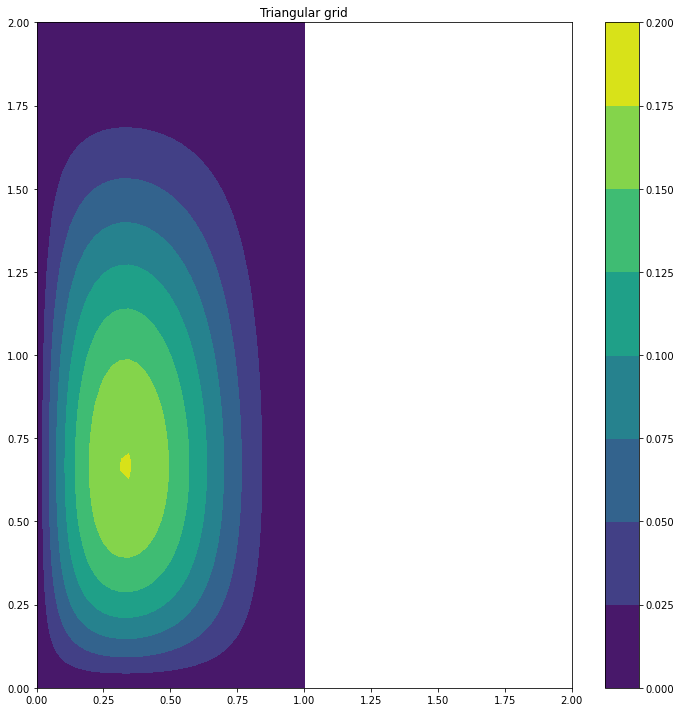

In [18]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = b

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)

# ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

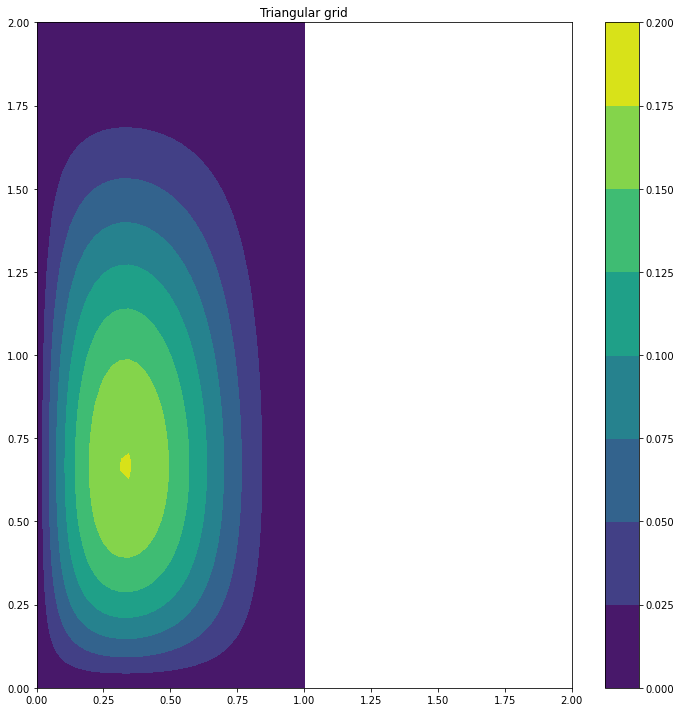

In [19]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)
ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

In [28]:
def show_success(index):
    point_index = int(len(points) * index)

    print("Exact solution: \t", ex[point_index])
    print("Approximate solution: \t", b[point_index])
    print("Error: \t\t\t", np.abs(ex[point_index] - b[point_index]))
    print('{:.2e}'.format(np.abs(ex[point_index] - b[point_index])))
    print()


In [29]:
for coef in [0, 0.1, 0.57, 0.81]:
    show_success(coef)

Exact solution: 	 0.0
Approximate solution: 	 0.0
Error: 			 0.0
0.00e+00

Exact solution: 	 0.09040574077516794
Approximate solution: 	 0.09040574077516789
Error: 			 5.551115123125783e-17
5.55e-17

Exact solution: 	 0.02460336685180664
Approximate solution: 	 0.024603366851806682
Error: 			 4.163336342344337e-17
4.16e-17

Exact solution: 	 0.011840544641017914
Approximate solution: 	 0.011840544641017962
Error: 			 4.85722573273506e-17
4.86e-17



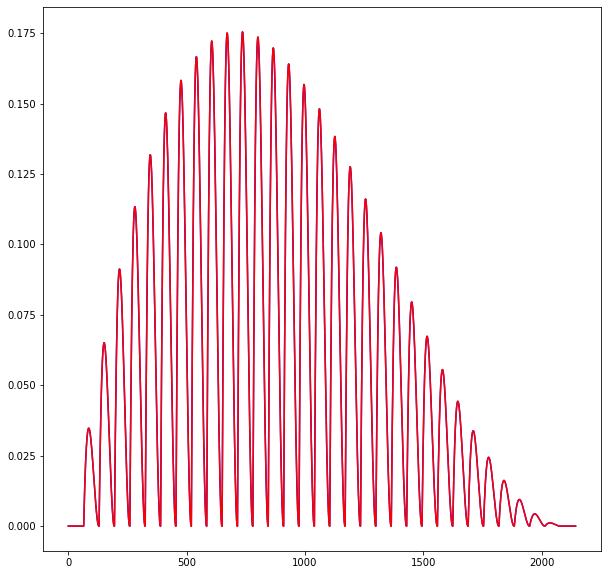

In [22]:
mesh = range(len(b))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(mesh, ex, 'blue')
ax.plot(mesh, b, 'red')
